In [1]:
import matplotlib.pyplot as plt
import xarray as xr

from ska_sdp_distributed_self_cal_prototype import subgrid

In [2]:
infile = (
    "/Users/seanstansill/Code/SKA_datasets/midbands_averaged_xradio.zarr/"
    "midbands_averaged_xradio.zarr_ddi_0_intent__field_id_0/MAIN"
)

In [3]:
ds = xr.open_zarr(infile, consolidated=False)

In [4]:
ds = ds.isel(time=[*range(1000)])
ds

<xarray.Dataset>
Dimensions:                     (time: 1000, baseline_id: 1891, frequency: 10,
                                 polarization: 4, uvw_label: 3)
Coordinates:
    baseline_antenna1_id        (baseline_id) int32 ...
    baseline_antenna2_id        (baseline_id) int32 ...
  * baseline_id                 (baseline_id) int64 0 1 2 3 ... 1888 1889 1890
  * frequency                   (frequency) float64 1.384e+08 ... 1.489e+08
  * polarization                (polarization) <U2 'XX' 'XY' 'YX' 'YY'
  * time                        (time) float64 1.514e+09 1.514e+09 ... 1.514e+09
  * uvw_label                   (uvw_label) <U1 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 ...
    FLAG                        (time, baseline_id, frequency, polarization) bool ...
    TIME_CENTROID               (time, baseline_id) float64 ...
    UVW                         (time, baseline_id, uvw_label) float64 ...
    VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 ...
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 ...
Attributes:
    data_groups:  {'base': {'flag': 'FLAG', 'uvw': 'UVW', 'visibility': 'VISI...
    ddi:          0
    intent:

In [5]:
# Lazily select the u and v values of the DataArray
u_lazy = ds["UVW"].sel(uvw_label="u")
v_lazy = ds["UVW"].sel(uvw_label="v")

# Get the max and min values for u and v to create subgrids
max_u = u_lazy.max().values
min_u = u_lazy.min().values
max_v = v_lazy.max().values
min_v = v_lazy.min().values

In [6]:
print(max_u)
print(max_v)
print(min_u)
print(min_v)

74426.39631726897
116091.17304600921
-56668.947887851464
-63308.71374432686


In [7]:
grid_box = (min_u, max_u, min_v, max_v)

num_subgrids = (8, 8)

subgrid_bounds = subgrid.subgrid_bounds(grid_box, num_subgrids)

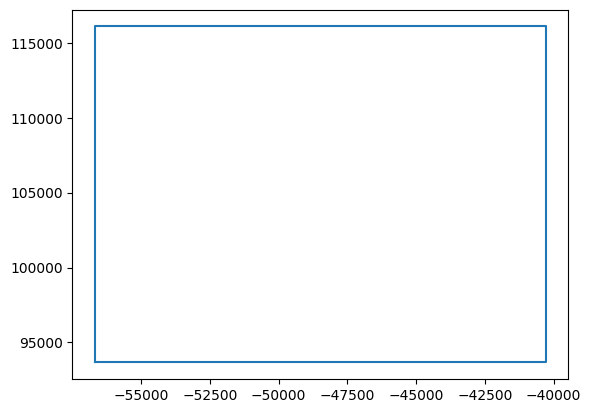

In [8]:
u_min, u_max, v_min, v_max = subgrid_bounds[0]
x_values = [u_min, u_max, u_max, u_min, u_min]
y_values = [v_min, v_min, v_max, v_max, v_min]


plt.plot(x_values, y_values)
plt.show()

In [9]:
def plot_all_subgrids(subgrid_bounds, label=""):
    colour = "#1f77b4"

    for i in range(subgrid_bounds.shape[0]):
        subgrid_bound = subgrid_bounds[i]
        u_min, u_max, v_min, v_max = subgrid_bound

        x_values = [u_min, u_max, u_max, u_min, u_min]
        y_values = [v_min, v_min, v_max, v_max, v_min]

        if 0 == i:
            plt.plot(x_values, y_values, c=colour, label=label)
        else:
            plt.plot(x_values, y_values, c=colour)

In [10]:
u_eager = u_lazy.values
v_eager = v_lazy.values

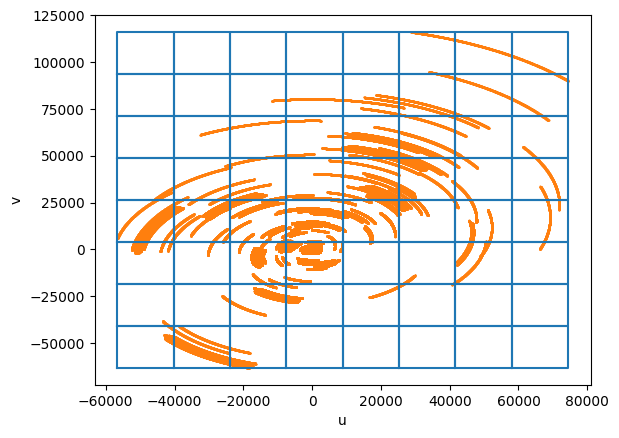

In [11]:
plt.plot(u_eager, v_eager, ".", c="#ff7f0e", ms=1)
plot_all_subgrids(subgrid_bounds)
plt.xlabel("u")
plt.ylabel("v")
plt.show()

In [12]:
dataset_partition = subgrid.get_xarray_dataset_partition(ds, subgrid_bounds[27])

In [13]:
dataset_partition

<xarray.Dataset>
Dimensions:                     (time_baseline_id: 4459, frequency: 10,
                                 polarization: 4, uvw_label: 3)
Coordinates:
    baseline_antenna1_id        (time_baseline_id) int32 ...
    baseline_antenna2_id        (time_baseline_id) int32 ...
    baseline_id                 (time_baseline_id) int64 1808 1866 ... 1831 1833
  * frequency                   (frequency) float64 1.384e+08 ... 1.489e+08
  * polarization                (polarization) <U2 'XX' 'XY' 'YX' 'YY'
    time                        (time_baseline_id) float64 1.514e+09 ... 1.51...
  * uvw_label                   (uvw_label) <U1 'u' 'v' 'w'
Dimensions without coordinates: time_baseline_id
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time_baseline_id) float64 ...
    FLAG                        (time_baseline_id, frequency, polarization) bool ...
    TIME_CENTROID               (time_baseline_id) float64 ...
    UVW                         (time_baseline_id, uvw_label) float64 ...
    VISIBILITY                  (time_baseline_id, frequency, polarization) complex64 ...
    WEIGHT                      (time_baseline_id, frequency, polarization) float32 ...
Attributes:
    data_groups:  {'base': {'flag': 'FLAG', 'uvw': 'UVW', 'visibility': 'VISI...
    ddi:          0
    intent:

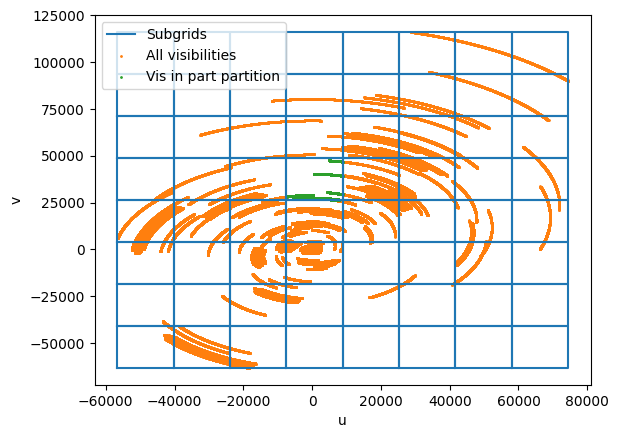

In [14]:
u_part = dataset_partition["UVW"].sel(uvw_label="u")
v_part = dataset_partition["UVW"].sel(uvw_label="v")

plot_all_subgrids(subgrid_bounds, label="Subgrids")
plt.scatter(u_eager, v_eager, c="#ff7f0e", s=1, label="All visibilities")
plt.scatter(u_part, v_part, c="#2ca02c", s=1, label="Vis in part partition")
plt.xlabel("u")
plt.ylabel("v")
plt.legend(loc="upper left")
plt.show()